# Explore NREL-118 Data


The dataset contains information about the IEEE-118 power system with several modifications (further "NREL-118"), which are presented and described [in the paper "An Extended IEEE 118-Bus Test System With High Renewable Penetration"](https://ieeexplore.ieee.org/document/7904729). The description given in this notebook is mostly from the paper and [from the FAQ file](../data/raw/nrel118/additional-files-mti-118/FAQ%20on%20NREL%20118.docx).

The data were downloaded on 07/22/2022 02:27:42 UTC using [this script](../src/data/download_nrel118.py) and stored in several files, which will be explained below.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# To use seaborn style for plots
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("talk")
sns_palette = sns.color_palette(plt.cm.get_cmap("tab20c").colors)

# Path to the folder with data
path_data = os.path.join("..", "data", "raw", "nrel118")

## Power System Data

In [2]:
# Path to the folder with power system data
power_system_files = os.path.join(path_data, "additional-files-mti-118")

### Buses

The model is based [on IIT 2004 transmission representation](http://motor.ece.iit.edu/data/JEAS_IEEE118.doc). However, the NREL-118 system consists of three regions, each of which has a different load profile.

In [3]:
# Load data
buses = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Buses.csv"), header=0
)
buses.head(5)

,Bus Name,Region,Load Participation Factor
0,bus026,R1,0.000000
1,bus010,R1,0.000000
2,bus025,R1,0.000000
3,bus012,R1,0.043466
4,bus015,R1,0.083238


In [4]:
# Ensure bus names are unique
assert buses["Bus Name"].is_unique, "Bus names are not unique."

# Get the number of buses
print(f"The system has {len(buses)} buses.")

The system has 118 buses.


In [5]:
# Each bus belongs to one of three regions
buses["Region"].value_counts()

R2    48
R1    42
R3    28
Name: Region, dtype: int64

The column "Load Participation Factor" means the portion of region load that is placed in the current bus. The factors were also taken from the IIT 2004 system and normalized by region.

In [6]:
# Number of buses with load per regions
loads = buses["Load Participation Factor"] > 0
buses.loc[loads, "Region"].value_counts()

R2    37
R1    30
R3    24
Name: Region, dtype: int64

### Lines

The line characteristics taken [from the IIT 2004 version](http://motor.ece.iit.edu/data/JEAS_IEEE118.doc) are the reactance and resistance (p.u.). IIT lines’ maximum flow levels were multiplied by the factor by which total system’s installed capacity increased (x3.5) and rounded for convenience.

In [7]:
# Load data
lines = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Lines.csv"), header=0
)
inter_lines = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Interregional lines.csv"),
    header=0,
)

# The meaning of the columns can be easily obtained from their names
lines.head(5)

,Line Name,Bus from,Bus to,Max Flow (MW),Min Flow (MW),Reactance (p.u.),Resistance (p.u.)
0,line001,bus001,bus002,600,-600,0.09990,0.03030
1,line002,bus001,bus003,600,-600,0.04240,0.01290
2,line003,bus004,bus005,1700,-1700,0.00798,0.00176
3,line004,bus003,bus005,600,-600,0.10800,0.02410
4,line005,bus005,bus006,600,-600,0.05400,0.01190


In [8]:
# Ensure line names are unique
assert lines["Line Name"].is_unique, "Line names are not unique."

# Get the number of lines
print(f"The system has {len(lines)} lines.")

The system has 186 lines.


In [9]:
# This shows which lines are between regions
# The meaning of the columns can be easily obtained from their names
inter_lines.head(5)

,Line,Node From,Node To,Region node from,Region node to,Is line crossing regions? (1=yes),Line capacity of inter-regional lines
0,line001,node001,node002,R1,R1,0,NaN
1,line002,node001,node003,R1,R1,0,NaN
2,line003,node004,node005,R1,R1,0,NaN
3,line004,node003,node005,R1,R1,0,NaN
4,line005,node005,node006,R1,R1,0,NaN


In [10]:
# Show only interregional lines
inter_lines[inter_lines["Is line crossing regions? (1=yes)"] == 1]

,Line,Node From,Node To,Region node from,Region node to,Is line crossing regions? (1=yes),Line capacity of inter-regional lines
174,line044,node015,node033,R1,R2,1,600.0
175,line045,node019,node034,R1,R2,1,600.0
176,line054,node030,node038,R1,R2,1,600.0
177,line108,node069,node070,R2,R1,1,1700.0
178,line116,node069,node075,R2,R1,1,1700.0
179,line120,node075,node077,R1,R2,1,600.0
180,line128,node077,node082,R2,R3,1,700.0
181,line148,node080,node096,R2,R3,1,600.0
182,line157,node096,node097,R3,R2,1,600.0
183,line158,node098,node100,R2,R3,1,600.0


### Generators


The total electricity generation capacity installed was increased 3.5 times compared to the original IEEE-118 system, but the generation distribution throughout the buses was maintained after normalizing the participation factors by region.

The dataset contains 10 types of generators: steam turbines (ST) powered by coal, gas and other fuels, internal combustion engines (ICE) powered by gas, combustion turbines (CT) powered by gas and oil, gas combined-cycle turbines (CC), photovoltaics (referred simply as solar), hydro and biomass generators, and wind turbines.

All the generators have the following parameters: maximum capacity (MW), minimum stable level (MW), heat rate base (MMBTU/h), heat rate increment (BTU/kWh), load point (MW), start cost (\$), VO&M charge (\$/MWh), minimum up time (h), minimum down time (h), maximum ramp up (MW/min), maximum ramp down (MW/min).

In [11]:
# Load data
gens = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Generators.csv"),
    header=0,
    sep=";",
    decimal=",",
).dropna(how="all")
gens.head(5)

,Generator Name,Node of connection,Category,Units,Max Capacity (MW),Commit,Data File of Commit,Scenario of Commit,Heat Rate Base (MMBTU/hr),Heat Rate Inc Band 1 (BTU/kWh),...,Max Ramp Up (MW/min),Max Ramp Up Penalty ($/MW),Min Down Time (h),Min Up Time (h),Min Stable Level (MW),% of min stable level,New stable level (MW),Escalator of Min Stable Level,Start Cost ($),VO&M Charge ($/MWh)
0,Biomass 01,node012,1. Committed DA,1.0,3.0,0.0,DA UC,RT,10.91,12120.0,...,0.42,450.0,1.0,1.0,0.90,30%,0.90,Biomass 01,15.90,1.91
1,Biomass 02,node012,1. Committed DA,1.0,3.0,0.0,DA UC,RT,10.91,12120.0,...,0.42,450.0,1.0,1.0,0.90,30%,0.90,Biomass 02,15.90,1.91
2,Biomass 03,node103,1. Committed DA,1.0,1.2,0.0,DA UC,RT,4.36,12120.0,...,0.42,450.0,1.0,1.0,0.36,30%,0.36,Biomass 03,6.36,1.91
3,Biomass 04,node103,1. Committed DA,1.0,1.2,0.0,DA UC,RT,4.36,12120.0,...,0.42,450.0,1.0,1.0,0.36,30%,0.36,Biomass 04,6.36,1.91
4,Biomass 05,node012,1. Committed DA,1.0,1.3,0.0,DA UC,RT,4.73,12120.0,...,0.42,450.0,6.0,6.0,0.26,20%,0.26,Biomass 05,6.89,1.91


In [12]:
# All generator parameters
print(gens.columns.values)

['Generator Name' 'Node of connection' 'Category' 'Units'
 'Max Capacity (MW)' 'Commit' 'Data File of Commit' 'Scenario of Commit'
 'Heat Rate Base (MMBTU/hr)' 'Heat Rate Inc Band 1 (BTU/kWh)'
 'Heat Rate Inc Band 2 (BTU/kWh)' 'Heat Rate Inc Band 3 (BTU/kWh)'
 'Heat Rate Inc Band 4 (BTU/kWh)' 'Heat Rate Inc Band 5 (BTU/kWh)'
 'Load Point Band 1 (MW)' 'Load Point Band 2 (MW)'
 'Load Point Band 3 (MW)' 'Load Point Band 4 (MW)'
 'Load Point Band 5 (MW)' 'Escalator of Load Point (all bands)'
 'Max Ramp Down (MW/min)' 'Max Ramp Down Penalty ($/MW)'
 'Max Ramp Up (MW/min)' 'Max Ramp Up Penalty ($/MW)' 'Min Down Time (h)'
 'Min Up Time (h)' 'Min Stable Level (MW)' '% of min stable level'
 'New stable level (MW)' 'Escalator of Min Stable Level' 'Start Cost ($)'
 'VO&M Charge ($/MWh)']


Some parameters require explanation:
- "Category" --- there are five categories here (Committed DA, Committed RT, Solar, Wind, Hydro). Slow generators have to commit in DA, and very fast generators do not need to commit one day ahead of schedule.
- "Units" --- here each generator corresponds to one unit.
- "Commit", "Data File of Commit", and "Scenario of Commit" --- "Commit" variable used [by Plexos](https://www.energyexemplar.com/plexos) to understand which generators can commit in which model/market. Commit >= 0 means a hard constraint, commit = 0 (do no commit). Commit =- 1 is the default value, i.e. that unit is left without a hard constraint and can commit freely based on the optimization. See more information about "Commit", "Data File of Commit", and "Scenario of Commit" [in the FAQ](../data/raw/nrel118/additional-files-mti-118/FAQ%20on%20NREL%20118.docx).
- "Escalator of Min Stable Level" and "Escalator of Load Point (all bands)" --- escalators are used to adjust generation profile to seasons, see [Section "Escalators"](#escalators)

In [13]:
# Ensure generator names are unique
assert gens["Generator Name"].is_unique, "Generator names are not unique."

# Get the number of generators
print(f"The system has {len(gens)} generators.")

The system has 327 generators.


In [14]:
# Show the distribution of generation by type and region
gen_type = gens["Generator Name"].str.split(" ").str[0].rename("Gen Type").to_frame()
gen_type["Capacity, MW"] = gens["Max Capacity (MW)"]
bus_regions = buses[["Bus Name", "Region"]]
bus_regions["Bus"] = (
    bus_regions["Bus Name"].str.lstrip("bus").str.lstrip("0").astype(int)
)
gen_type["Bus"] = (
    gens["Node of connection"].str.lstrip("node").str.lstrip("0").astype(int)
)
gen_type = pd.merge(gen_type, bus_regions[["Region", "Bus"]], on="Bus", how="left")
gen_type["Count"] = 1
gen_stat_reg_type = pd.pivot_table(
    gen_type,
    values=["Capacity, MW", "Count"],
    index=["Region", "Gen Type"],
    aggfunc=np.sum,
)
gen_stat_reg_type

Capacity, MW  Count
Region Gen Type                     
R1     Biomass          58.25     35
       CC             5812.07     19
       CT             1579.80     27
       Hydro             0.80      1
       ST             1537.20      8
       Solar          1205.97     33
       Wind            328.90     13
R2     Biomass          16.50      4
       CC             1743.86      7
       CT              516.90      9
       Geo              22.00      1
       Hydro         18643.47     40
       ICE              50.40      6
       Solar           444.37      5
R3     Biomass          40.17     23
       CC             3436.13     12
       CT             1549.30     35
       Hydro             6.00      2
       ICE               3.25      1
       ST              978.35      5
       Solar          1795.43     37
       Wind            749.00      4

In [15]:
# Show the distribution of generation by region only
gen_stat_reg = pd.pivot_table(
    gen_type,
    values=["Capacity, MW", "Count"],
    index=["Region"],
    aggfunc=np.sum,
)
gen_stat_reg

,"Capacity, MW",Count
Region,,
R1,10522.99,136
R2,21437.50,72
R3,8557.63,119


### Hydro generators

The model includes 15 dispatchable and 28 non-dispatchable hydro generators. This means that the dispatch level of 15 hydro units is estimated according to the optimal system operation.

On the other side, 28 hydro generators are constrained to a fixed generation. Four of the 28 non-dispatchable units (Hydro 36-39) have a fixed load defined per month (presented in this section), and the other 24 non-dispatchable (Hydro 40-43, Hydro 16-35) units have a fixed load defined with a time series file (presented [in section Time-series data](#Time-series-data)).

In [16]:
# Load data
hydro = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Hydro_nondipatchable.csv"),
    header=0,
)

hydros_36_39 = hydro["Generator"].isin(["Hydro 36", "Hydro 37", "Hydro 38", "Hydro 39"])
hydro[hydros_36_39].head(10)

,Generator,Property,Value,Units,Band,Date From,Date To,Timeslice,Escalator,Data File,Scenario,Memo,Category
20,Hydro 36,Fixed Load,0.51,MW,1,NaN,NaN,M1,NaN,NaN,NaN,NaN,Hydro
21,Hydro 36,Fixed Load,0.43,MW,1,NaN,NaN,M10,NaN,NaN,NaN,NaN,Hydro
22,Hydro 36,Fixed Load,0.41,MW,1,NaN,NaN,M11,NaN,NaN,NaN,NaN,Hydro
23,Hydro 36,Fixed Load,0.41,MW,1,NaN,NaN,M12,NaN,NaN,NaN,NaN,Hydro
24,Hydro 36,Fixed Load,0.54,MW,1,NaN,NaN,M2,NaN,NaN,NaN,NaN,Hydro
25,Hydro 36,Fixed Load,0.56,MW,1,NaN,NaN,M3,NaN,NaN,NaN,NaN,Hydro
26,Hydro 36,Fixed Load,0.69,MW,1,NaN,NaN,M4,NaN,NaN,NaN,NaN,Hydro
27,Hydro 36,Fixed Load,0.90,MW,1,NaN,NaN,M5,NaN,NaN,NaN,NaN,Hydro
28,Hydro 36,Fixed Load,0.93,MW,1,NaN,NaN,M6,NaN,NaN,NaN,NaN,Hydro
29,Hydro 36,Fixed Load,0.90,MW,1,NaN,NaN,M7,NaN,NaN,NaN,NaN,Hydro


### Escalators

Thr escalators are simple multipliers of certain generator characteristics. They are used to adjust a certain generation profile to seasons or other time slices.

In this case, escalators adjust minimum stable level, load point and rating, per month. Thus, each of these generator characteristics will be scaled based on the escalator for each month of the year. Escalators are applied to all the generators, except wind, solar and hydro.


In [17]:
# Load data
escalators = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Escalators.csv"),
    header=0,
)
escalators.head(5)

,Escalator,Value,Timeslice (month)
0,Biomass 1,0.3500,M1
1,Biomass 1,0.3433,M10
2,Biomass 1,0.3733,M11
3,Biomass 1,0.3533,M12
4,Biomass 1,0.3700,M2


### Fuels

The dataset includes emission rates of carbon dioxide (CO2), nitrogen oxides (NOx), and sulfur oxides (SOx), for each fuel type. One single value of these gas emissions per fuel type is used across the three regions.

In [18]:
# Load data
fuels = pd.read_csv(
    filepath_or_buffer=os.path.join(power_system_files, "Fuels and emission rates.csv"),
    header=0,
)
fuels.head(5)

,Unnamed: 0,Fue price ($/MMBTU),CO2 Emissions productiion rate (lb/MMBTU),NOX emissions production rate (lb/MMBTU),SO2 emissions production rate (lb/MMBTU)
0,Coal,1.8,203.5,0.382413,0.33030
1,Natural gas,5.4,118.0,0.079000,0.00060
2,Oil,21.0,123.1,0.176000,0.00579
3,Biomass,2.4,130.0,0.176636,0.00579
4,Geothermal,0.0,0.0,0.176636,0.00579


### Types of solar and wind plants

Here is the description of types of wind and solar plants which have been chosen so as to be in close geographic proximity to the load zones where they are connected, ensuring that the meteorological conditions which impact load, wind, and solar are consistent.

The aggregated wind and solar profiles are comprised of a number of individual wind or solar plants, each of which has an independent time series of power output whose correlation is dependent on the geographic distance between the plants.

In [19]:
# Load data
location = pd.read_csv(
    filepath_or_buffer=os.path.join(
        power_system_files, "Geographical Location Nodes RE IEEE 118.csv"
    ),
    header=0,
)
location.head(10)

,Name IEEE 118,Zone,Generator Type
0,Solar 3,R2,DG-BTM
1,Solar 3,R2,DG-BTM
2,Solar 3,R2,DG-BTM
3,Solar 73,R2,SolarPV-Tracking
4,Solar 74,R2,SolarPV-Tracking
5,Solar 75,R2,SolarPV-Tracking
6,Wind 1,R1,WT-Onshore
7,Wind 2,R1,WT-Onshore
8,Solar 63,R1,SolarPV-Tracking
9,Solar 64,R1,SolarPV-Tracking


In [20]:
# Distribution of generator types by location
location["Generator Type"].value_counts()

SolarPV-NonTracking    58
WT-Onshore             17
SolarPV-Tracking       13
DG-BTM                 11
SolarThermal-CSP6       1
Name: Generator Type, dtype: int64

Description:
- SolarPV-NonTracking --- solar panel that does not have a tracking system to follow the sun and change its position for maximize the power output.
- SolarPV-Tracking --- solar panel with tracking system.
- SolarThermal-CSP6 --- concentrating solar-thermal power, [here](https://www.energy.gov/eere/solar/concentrating-solar-thermal-power-basics) is the description.
- WT-Onshore --- onshore wind turbine located on land driven by the natural movement of the air.
- DG-BTM --- distributed generation located on the customer side of the meter (behind the meter).



## Time-Series Data

In [21]:
time_series_files = os.path.join(path_data, "Input files")

In [22]:
def show_ts_data_plot(data: pd.DataFrame, plot_name: str) -> plt:
    """Build plot for time-series data.

    Args:
        data: dataframe with datetime and value columns
        plot_name: name of plot.

    Returns:
        Matplotlib plot.
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.lineplot(data=data, x="datetime", y="value", palette=sns_palette, ax=ax)
    ax.set_ylabel("Value")
    ax.set_xlabel("Date")
    ax.set_title(plot_name)

### Day-ahead and real-time forecasts

The dataset contains one year of time-synchronous hourly actuals (i.e. real time, RT) of wind power, solar power, and load. Also, one year of time-synchronous hourly day-ahead (DA) forecasts of wind power, solar power, and load are also provided.

Load data are synthetic load data obtained from neural net regressions with 1980-2012 input weather and load data. Wind data are provided [by the Wind Toolkit](https://www.nrel.gov/electricity/transmission/wind_toolkit.html), while solar data is provided [by the National Solar Radiation Data Base (NSRDB)](https://nsrdb.nrel.gov/data-viewer).

In [23]:
# The structure of files is the same of RT and DA forecast
# So, let's show only RT data
rt_ts_path = os.path.join(time_series_files, "RT")

#### Load

In [24]:
load_rt_ts_path = os.path.join(rt_ts_path, "Load")
load_rt_ts_files = os.listdir(load_rt_ts_path)
print(load_rt_ts_files)

['.DS_Store', 'LoadR1RT.csv', 'LoadR2RT.csv', 'LoadR3RT.csv']


In [25]:
load_R2_rt_ts = pd.read_csv(
    filepath_or_buffer=os.path.join(load_rt_ts_path, "LoadR2RT.csv"), header=0
)
load_R2_rt_ts.head(10)

,DATETIME,value
0,1/1/24 1:00,1904.444801
1,1/1/24 2:00,1726.221344
2,1/1/24 3:00,1694.141121
3,1/1/24 4:00,1679.883245
4,1/1/24 5:00,1726.221344
5,1/1/24 6:00,1817.709385
6,1/1/24 7:00,1936.525024
7,1/1/24 8:00,2032.765691
8,1/1/24 9:00,2164.651049
9,1/1/24 10:00,2241.881214


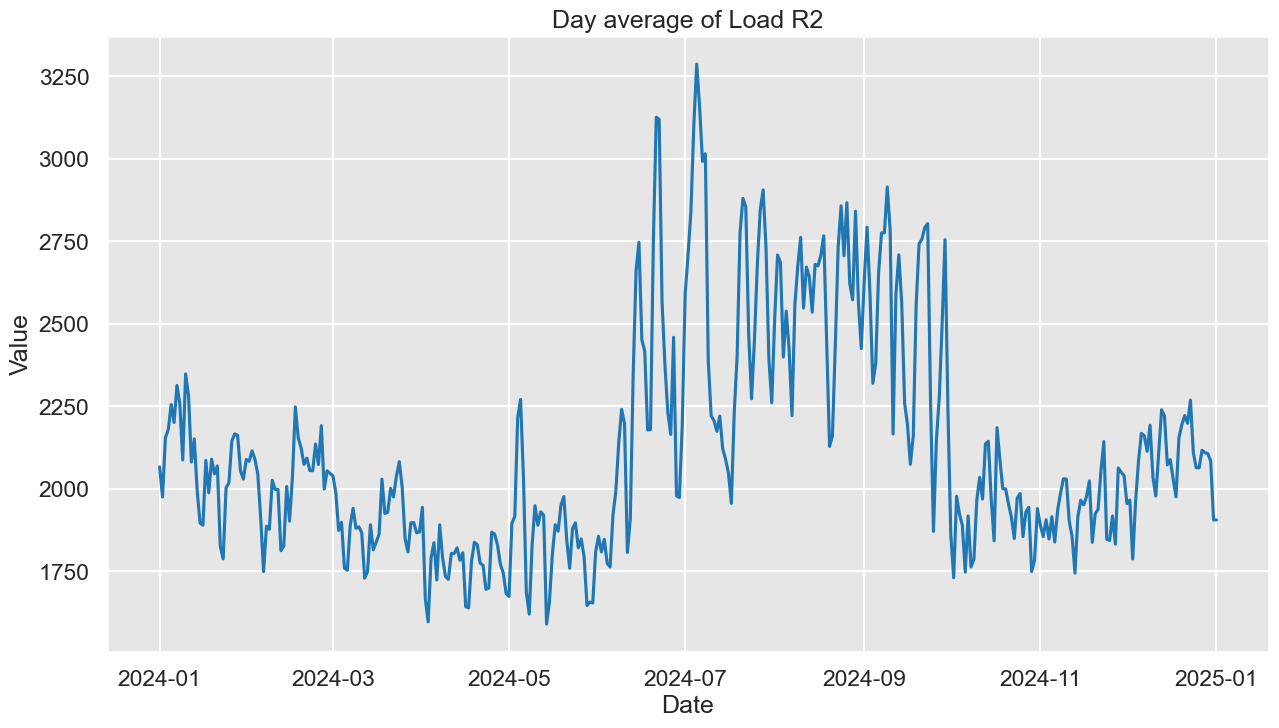

In [26]:
# Show change of load
load_R2_rt_ts.columns = [col.lower() for col in load_R2_rt_ts.columns]
load_R2_rt_ts["datetime"] = pd.to_datetime(load_R2_rt_ts["datetime"])
load_R2_rt_ts_per_day = load_R2_rt_ts.resample("D", on="datetime").mean()
show_ts_data_plot(load_R2_rt_ts_per_day, "Day average of Load R2")

#### Solar

In [27]:
solar_rt_ts_path = os.path.join(rt_ts_path, "Solar")
solar_rt_ts_files = os.listdir(solar_rt_ts_path)
print(solar_rt_ts_files)

['.DS_Store', 'Solar10RT.csv', 'Solar11RT.csv', 'Solar12RT.csv', 'Solar13RT.csv', 'Solar14RT.csv', 'Solar15RT.csv', 'Solar16RT.csv', 'Solar17RT.csv', 'Solar18RT.csv', 'Solar19RT.csv', 'Solar1RT.csv', 'Solar20RT.csv', 'Solar21RT.csv', 'Solar22RT.csv', 'Solar23RT.csv', 'Solar24RT.csv', 'Solar25RT.csv', 'Solar26RT.csv', 'Solar27RT.csv', 'Solar28RT.csv', 'Solar29RT.csv', 'Solar2RT.csv', 'Solar30RT.csv', 'Solar31RT.csv', 'Solar32RT.csv', 'Solar33RT.csv', 'Solar34RT.csv', 'Solar35RT.csv', 'Solar36RT.csv', 'Solar37RT.csv', 'Solar38RT.csv', 'Solar39RT.csv', 'Solar3RT.csv', 'Solar40RT.csv', 'Solar41RT.csv', 'Solar42RT.csv', 'Solar43RT.csv', 'Solar44RT.csv', 'Solar45RT.csv', 'Solar46RT.csv', 'Solar47RT.csv', 'Solar48RT.csv', 'Solar49RT.csv', 'Solar4RT.csv', 'Solar50RT.csv', 'Solar51RT.csv', 'Solar52RT.csv', 'Solar53RT.csv', 'Solar54RT.csv', 'Solar55RT.csv', 'Solar56RT.csv', 'Solar57RT.csv', 'Solar58RT.csv', 'Solar59RT.csv', 'Solar5RT.csv', 'Solar60RT.csv', 'Solar61RT.csv', 'Solar62RT.csv', 'Sola

In [28]:
solar_10_rt_ts = pd.read_csv(
    filepath_or_buffer=os.path.join(solar_rt_ts_path, "Solar10RT.csv"), header=0
)
solar_10_rt_ts.head(10)

,DATETIME,value
0,1/1/24 1:00,0.000000
1,1/1/24 2:00,0.000000
2,1/1/24 3:00,0.000000
3,1/1/24 4:00,0.000000
4,1/1/24 5:00,0.000000
5,1/1/24 6:00,0.000000
6,1/1/24 7:00,0.000000
7,1/1/24 8:00,0.000000
8,1/1/24 9:00,0.416689
9,1/1/24 10:00,1.368420


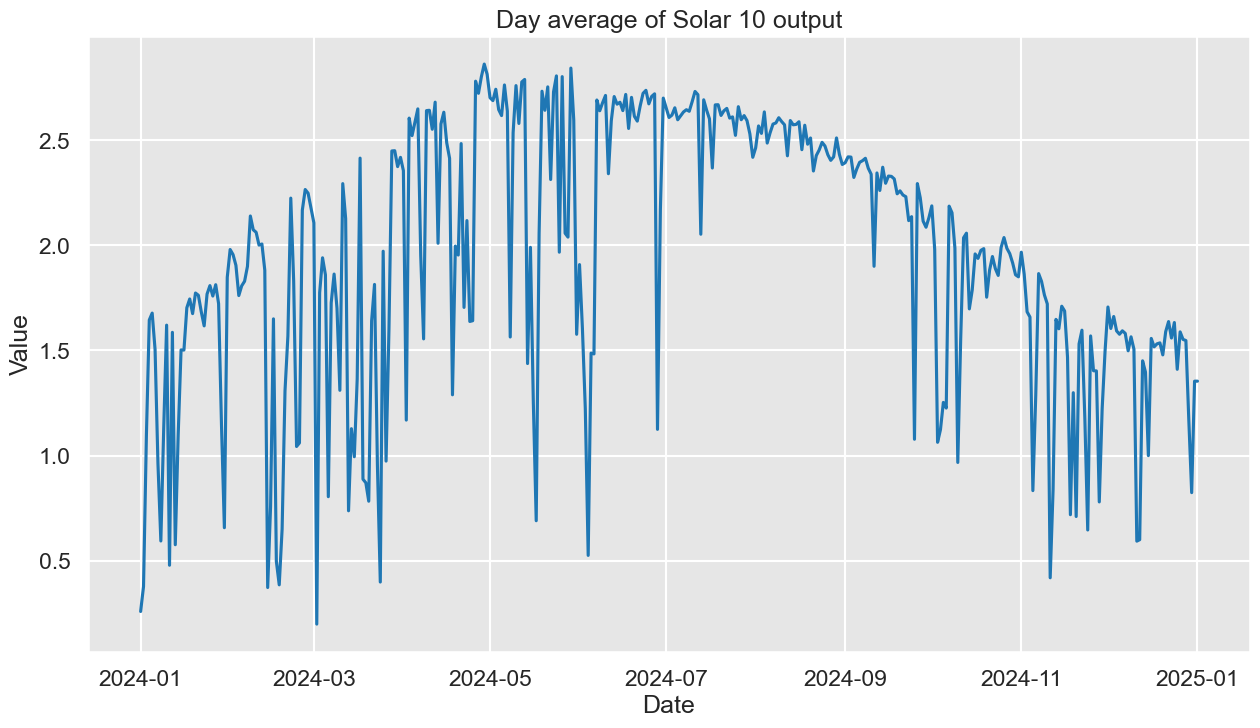

In [29]:
# Show change of output
solar_10_rt_ts.columns = [col.lower() for col in solar_10_rt_ts.columns]
solar_10_rt_ts["datetime"] = pd.to_datetime(solar_10_rt_ts["datetime"])
solar_10_rt_ts_per_day = solar_10_rt_ts.resample("D", on="datetime").mean()
show_ts_data_plot(solar_10_rt_ts_per_day, "Day average of Solar 10 output")

#### Wind

In [30]:
wind_rt_ts_path = os.path.join(rt_ts_path, "Wind")
wind_rt_ts_files = os.listdir(wind_rt_ts_path)
print(wind_rt_ts_files)

['.DS_Store', 'Wind10RT.csv', 'Wind11RT.csv', 'Wind12RT.csv', 'Wind13RT.csv', 'Wind14RT.csv', 'Wind15RT.csv', 'Wind16RT.csv', 'Wind17RT.csv', 'Wind1RT.csv', 'Wind2RT.csv', 'Wind3RT.csv', 'Wind4RT.csv', 'Wind5RT.csv', 'Wind6RT.csv', 'Wind7RT.csv', 'Wind8RT.csv', 'Wind9RT.csv']


In [31]:
wind_7_rt_ts = pd.read_csv(
    filepath_or_buffer=os.path.join(wind_rt_ts_path, "Wind7RT.csv"), header=0
)
wind_7_rt_ts.head(10)

,DATETIME,value
0,1/1/24 0:00,1.942837
1,1/1/24 1:00,4.622050
2,1/1/24 2:00,6.191502
3,1/1/24 3:00,9.045088
4,1/1/24 4:00,9.334108
5,1/1/24 5:00,9.357822
6,1/1/24 6:00,9.357843
7,1/1/24 7:00,9.357843
8,1/1/24 8:00,9.357817
9,1/1/24 9:00,9.356313


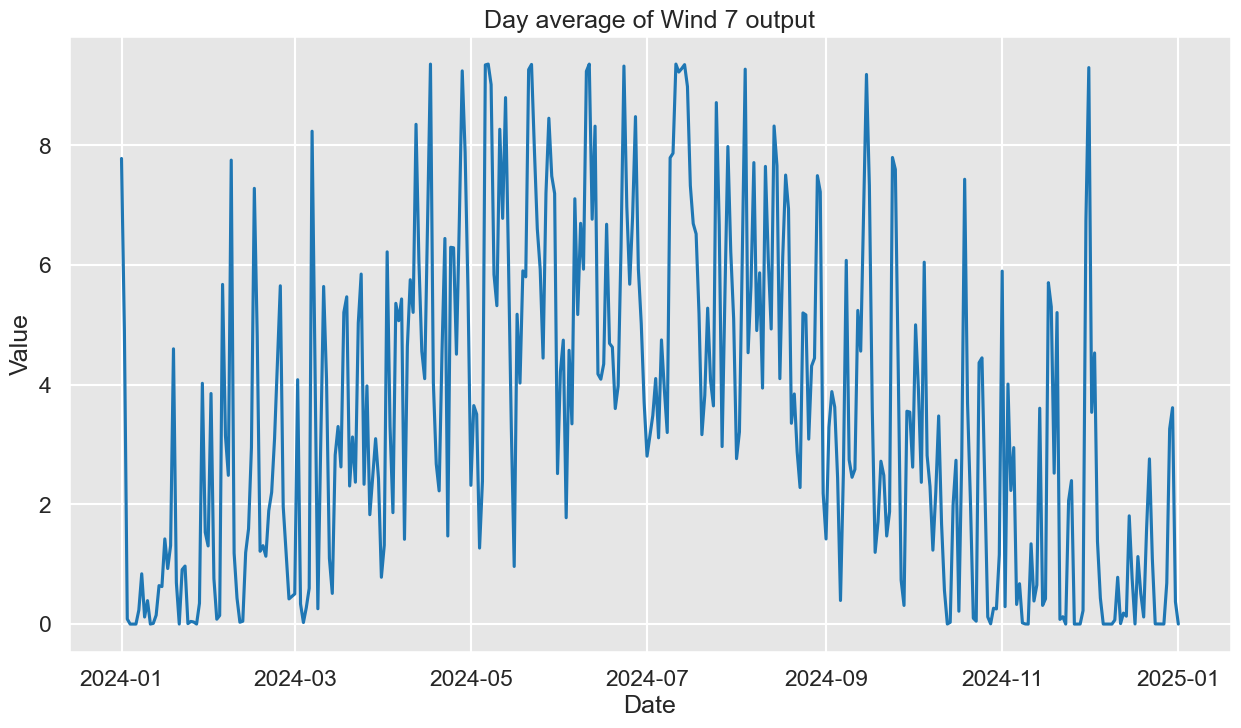

In [32]:
# Show change of output
wind_7_rt_ts.columns = [col.lower() for col in wind_7_rt_ts.columns]
wind_7_rt_ts["datetime"] = pd.to_datetime(wind_7_rt_ts["datetime"])
wind_7_rt_ts_per_day = wind_7_rt_ts.resample("D", on="datetime").mean()
show_ts_data_plot(wind_7_rt_ts_per_day, "Day average of Wind 7 output")

### Hydro power plants

Here is the output of 24 non-dispatchable hydro plants on an hourly basis. Other 4 non-dispatchable units (Hydro 36-39) have a fixed load defined per month ([presented earlier](#Hydro-generators)), and the dispatch level of 15 hydro units (Hydro 1-15) is estimated according to the optimal system operation.

In [33]:
hydro_ts_path = os.path.join(time_series_files, "Hydro")
hydro_ts_files = os.listdir(hydro_ts_path)
print(hydro_ts_files)

['Hydro 16.csv', 'Hydro 17.csv', 'Hydro 18.csv', 'Hydro 19.csv', 'Hydro 20.csv', 'Hydro 21.csv', 'Hydro 22.csv', 'Hydro 23.csv', 'Hydro 24.csv', 'Hydro 25.csv', 'Hydro 26.csv', 'Hydro 27.csv', 'Hydro 28.csv', 'Hydro 29.csv', 'Hydro 30.csv', 'Hydro 31.csv', 'Hydro 32.csv', 'Hydro 33.csv', 'Hydro 34.csv', 'Hydro 35.csv', 'Hydro 40.csv', 'Hydro 41.csv', 'Hydro 42.csv', 'Hydro 43.csv']


In [34]:
hydro_21_ts = pd.read_csv(
    filepath_or_buffer=os.path.join(hydro_ts_path, "Hydro 21.csv"), header=0
)
hydro_21_ts.head(10)

,DATETIME,Value
0,1/1/24 1:00,13.73772
1,1/1/24 2:00,7.60737
2,1/1/24 3:00,7.45680
3,1/1/24 4:00,7.42095
4,1/1/24 5:00,7.44246
5,1/1/24 6:00,7.36359
6,1/1/24 7:00,8.46777
7,1/1/24 8:00,29.32530
8,1/1/24 9:00,1.07550
9,1/1/24 10:00,0.00000


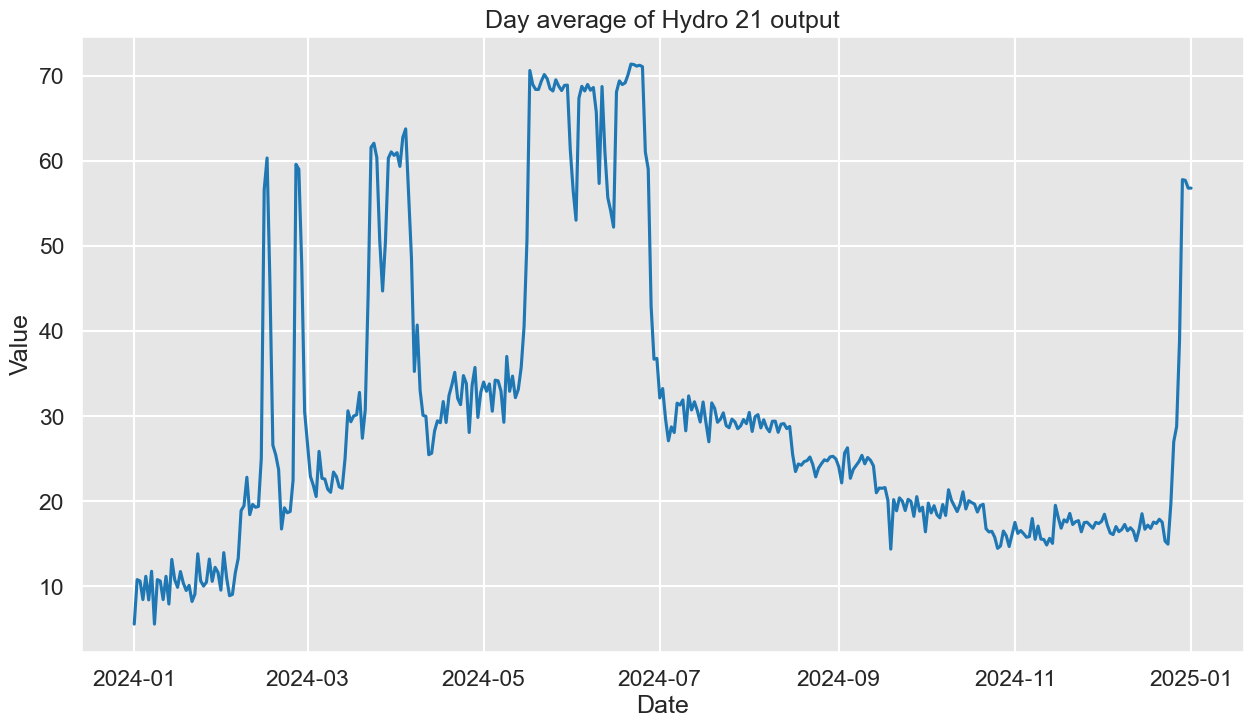

In [35]:
# Show change of output
hydro_21_ts.columns = [col.lower() for col in hydro_21_ts.columns]
hydro_21_ts["datetime"] = pd.to_datetime(hydro_21_ts["datetime"])
hydro_21_ts_per_day = hydro_21_ts.resample("D", on="datetime").mean()
show_ts_data_plot(hydro_21_ts_per_day, "Day average of Hydro 21 output")

### Fuel prices

Here is the information about fuel costs per month per region.

In [36]:
fuel_prices_path = os.path.join(time_series_files, "Others", "Fuel prices 2024.csv")
fuel_prices = pd.read_csv(filepath_or_buffer=fuel_prices_path, header=0)
fuel_prices.head(12)

,Datetime,Coal R1,Oil Distillate R1,Oil Distillate R2,Biomass R1,Biomass R2,Biomass R3,Natural Gas R1,Natural Gas R2,Natural Gas R3,Geo R1
0,1-Jan,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
1,1-Feb,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
2,1-Mar,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
3,1-Apr,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
4,1-May,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
5,1-Jun,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
6,1-Jul,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
7,1-Aug,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
8,1-Sep,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0
9,1-Oct,1.8,21,21,2.4,2.4,2.4,5.4,5.4,5.4,0


### Generator outages

The file shows the month, day and hour at which such unit was out of operation with either a forced Outage or maintenance. Value of 1 = true (i.e. out of service) for that hour.

In [37]:
gen_outputs_path = os.path.join(time_series_files, "Others", "GenOut.csv")
gen_outputs = pd.read_csv(filepath_or_buffer=gen_outputs_path, header=0)
gen_outputs.head(5)

,Name,Year,Month,Day,Period,Value
0,Biomass 01,2023,12,31,24,0
1,Biomass 01,2024,1,14,15,1
2,Biomass 01,2024,1,16,5,0
3,Biomass 01,2024,2,1,17,1
4,Biomass 01,2024,2,3,7,0


## Plexos Models

The dataset also contains [Plexos model as a plexos file](../data/raw/nrel118/mti-118-mt-da-rt-da-rt-reserves-all-generators.xml) and [Plexos model as a .xls file](../data/raw/nrel118/plexos-export.xls). These files were included with the intention that users of this test-bed can run the model, compare results and verify that they have set their system appropriately.
